In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

# Stolen Base Success

This could really use more data. For stealing second base, I have formulas that work for each season, or in the case of season 15, *almost* work. But some of them are rather "overfit"-feeling, and also the Season 15 one has 2 stubborn outliers I don't know what to do with. Fitting to all seasons at once (for rolls below 0.95) actually does really well too (9 outliers out of 2185), so I don't know to what extent the variation I'm seeing in these formulas actually is real...

Of note: The clearest change I can see in the data is that they added a cutoff for the threshold in season 14. For S14 and S15, no roll above 0.95 can be a success

In [2]:
all_files = glob.glob("../roll_data/*-steal_success.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)

season = 13
df = df[df["season"] == season]
len(df)

1791

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.5
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        # mul += 1.25
        pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul, attrs

def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul


In [26]:
# df["batter_mul"] = df.apply(get_batter_mul, axis=1)
# df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["batter_mul"] = df.apply(lambda x: 1, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
# df["pitcher_mul"] = df.apply(lambda x: 1, axis=1)
# df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)
df["fielder_mul"] = df.apply(get_pitcher_mul, axis=1)

In [27]:
# df["baserunner_n"] = [int(np.floor(len(x) / 40)) for x in df.loc[:, "baserunner_count"]]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [28]:
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    # had to do all this to make chunky and smooth work correctly
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
    #                               if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
    #                               else x[attr] * (1 + 0.2 * x["batter_vibes"]),
    #                               axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["batter_mul"] * (1 + 0.2 * df["batter_vibes"])

In [29]:
df = df.copy()
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [30]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])


df = df.copy()

In [31]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealSuccess0    1244
StealSuccess1     476
StealSuccess2      71
dtype: int64

In [32]:
# focus on stealing *second base* because it has the largest sample size
dfc = df[df["event_type"] == "StealSuccess0"].copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
# dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


# dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1) & (dfc["fielder_mul"] == 1)]

# dfc = dfc[dfc['stadium_id'].isna()]

len(dfc)

1244

In [33]:
dfc[dfc['passed']].loc[:, 'roll'].max()

0.9462016727410094

In [34]:
X = dfc[
    [
        "roll",
        "passed",
        # "batter_base_thirst_mul_vibe",
        "batter_laserlikeness_mul_vibe",
        # "pitcher_watchfulness_mul_vibe",
        "pitcher_anticapitalism_mul_vibe",
        # "pitcher_coldness_mul_vibe",
        # "laser_thirst",
        # "explaser",
        # "sinlaser",
        # "lasersq",
        # "laser3",
        # "laser4",
        # "laser5",
        # "thirstsq",
        # "cold_runners",
        # "fielder_omniscience_mul_vibe",
        # 'fielder_tenaciousness_mul_vibe',
        # "fielder_watchfulness_mul_vibe",
        # "fielder_watchfulness",
        "fielder_anticapitalism_mul_vibe",
        # "fielder_anticapitalism",
        # 'fielder_chasiness_mul_vibe',
        # "ballpark_grandiosity",
        # 'ballpark_fortification',
        # "ballpark_obtuseness",
        # 'ballpark_ominousness',
        # "ballpark_inconvenience",
        # "ballpark_viscosity",
        # "ballpark_forwardness",
        'ballpark_elongation',
        # 'ballpark_mysticism',
        # 'ballpark_filthiness',
    ]
]
X = X[X['roll'] < 0.95]

y = X["passed"]
X = X.drop("passed", axis=1)
len(X)

1179

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=10000000, C=10000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[203   2]
 [  1 973]]
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       205
        True       1.00      1.00      1.00       974

    accuracy                           1.00      1179
   macro avg       1.00      0.99      1.00      1179
weighted avg       1.00      1.00      1.00      1179

0.9974554707379135


In [36]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.73490056]


[(1.0, 'roll'),
 (-0.43758854035817873, 'batter_laserlikeness_mul_vibe'),
 (0.2959800636709444, 'fielder_anticapitalism_mul_vibe'),
 (0.16246903934134996, 'ballpark_elongation'),
 (0.09221231569503376, 'pitcher_anticapitalism_mul_vibe')]

## Best formulas so far

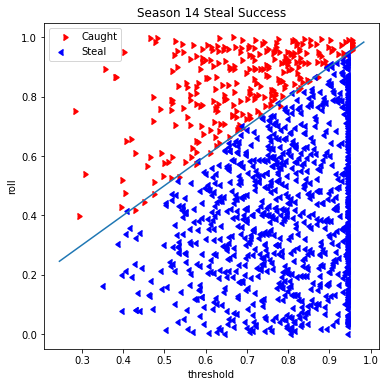

In [37]:
# this works for season 12, with no maximum threshold cutoff!
# elongation term is -0.05 for all data so the intercept is effectively 0.60
# if season == 11:
dfc.loc[(dfc["season"] == 11), "threshold"] = (0.65
                                               + 0.5 * dfc["batter_laserlikeness_mul_vibe"]
                                               - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
                                               - 0.10 * dfc["pitcher_anticapitalism_mul_vibe"]
                                               - 0.10 * dfc["ballpark_elongation"]
                                              )

# this works for season 13, with no maximum threshold cutoff!
# "2/3" as the intercept also works. this implies that stealing second got *slightly*
# easier in that season...
# if season == 12:
dfc.loc[(dfc["season"] == 12), "threshold"] = (0.666
                                               + 0.5 * dfc["batter_laserlikeness_mul_vibe"]
                                               - 0.30 * dfc["fielder_anticapitalism_mul_vibe"]
                                               - 0.10 * dfc["pitcher_anticapitalism_mul_vibe"]
                                               - 0.10 * dfc["ballpark_elongation"]
                                              )

# this works for season 14 but i really don't like how "overfit" it feels.
# there IS a threshold at 0.95 in season 14!
# if season == 13:
dfc.loc[(dfc["season"] == 13), "threshold"] = (0.8051
                                               + 0.420 * dfc["batter_laserlikeness_mul_vibe"]
                                               - 0.291 * dfc["fielder_anticapitalism_mul_vibe"]
                                               - 0.106 * dfc["pitcher_anticapitalism_mul_vibe"]
                                               - 0.255 * dfc["ballpark_elongation"]
                                              )
dfc.loc[((dfc["threshold"] > 0.95) & (dfc["season"] == 13)), "threshold"] = 0.95


# this *almost* works for season 15 but i really don't like how "overfit" it feels.
# also there are two weird stubborn outliers that I can't figure out how to get rid of.
# the SVC can't get rid of them either...
# there IS a threshold at 0.95 in season 15!
# if season == 14:
dfc.loc[(dfc["season"] == 14), "threshold"] = (0.675
                                               + 0.46 * dfc["batter_laserlikeness_mul_vibe"]
                                               - 0.302 * dfc["fielder_anticapitalism_mul_vibe"]
                                               - 0.091 * dfc["pitcher_anticapitalism_mul_vibe"]
                                               - 0.076 * dfc["ballpark_elongation"]
                                              )
dfc.loc[((dfc["threshold"] > 0.95) & (dfc["season"] == 14)), "threshold"] = 0.95


# this will use the most recent fit values
# dfc["threshold"] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         print(pair)
#         dfc["threshold"] += pair[0] * dfc[pair[1]]

# dfc.loc[(dfc["threshold"] > 0.95), "threshold"] = 0.95

y_val = "roll"
x_val = "threshold"
# x_val = "batter_watchfulness_mul_vibe"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Caught",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season {season+1} Steal Success")
# ax.set_ylim(0, 1.0)

if x_val == "threshold" or x_val == "svc":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

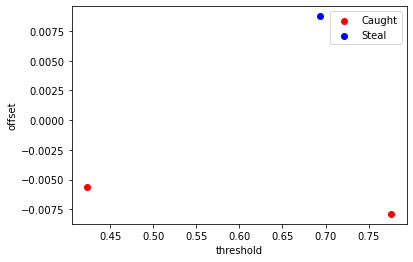

In [38]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "batter_laserlikeness_mul_vibe"
# x_val = "pitcher_anticapitalism_mul_vibe"
# x_val = "fielder_anticapitalism_mul_vibe"
# x_val = "ballpark_elongation"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Caught",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [39]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "fielder_mul",  # "baserunner_count",
        # "batter_vibes", "pitcher_vibes",
        "batter_laserlikeness_mul_vibe",
        "pitcher_anticapitalism_mul_vibe",
        "fielder_anticapitalism_mul_vibe",
        "ballpark_elongation",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
        "weather",
    ]
]
print(len(table))
print(sum(table.loc[:,"offset"]))
table.sort_values("offset", ascending=False)#[0:10]

3
-0.004797276053963129


,passed,offset,roll,threshold,pitcher_mul,batter_mul,fielder_mul,batter_laserlikeness_mul_vibe,pitcher_anticapitalism_mul_vibe,fielder_anticapitalism_mul_vibe,ballpark_elongation,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,weather
2050,True,0.008742,0.702256,0.693513,1.010000,1,1.010000,1.012605,1.342483,0.876485,0.547139,Commissioner Vapor,Stevenson Heat,Christian Combs,PERK,ALTERNATE;FRIEND_OF_CROWS,FIRE_EATER,HIGH_PRESSURE;OVERPERFORMING,SINKING_SHIP,13,81,2c701ea0-fe1e-456a-bba2-395d8ad9f125,357,Weather.FLOODING
3565,False,-0.005643,0.417097,0.422740,1.012121,1,1.012121,0.688266,0.812793,1.599724,0.469630,Dudley Mueller,Chambers Simmons,Glabe Moon,SIPHON,NaN,SIPHON;PERK,BASE_INSTINCTS,GROWTH,13,24,74b4deb8-1c64-4b7e-8039-8b0f3d87ee0a,282,Weather.REVERB
2394,False,-0.007896,0.768533,0.776429,1.250000,1,1.250000,0.597447,0.297761,0.430085,0.481888,Jessica Telephone,Beasley Gloom,Alston Cerveza,SUPERALLERGIC;HONEY_ROASTED;EGO1,NaN,NaN,NaN,HIGH_PRESSURE,13,93,aeac9740-6fd6-43cb-86a2-a1f5ed56b195,308,Weather.FLOODING


In [40]:
0.711224*0.5

0.355612

In [41]:
0.711224/1.017172

0.6992170449048931

In [42]:
0.6992170449048931*.5

0.34960852245244656

In [43]:
0.355612 - 0.34960852245244656

0.006003477547553426

In [44]:
# outliers.sort_values('roll', ascending=True).style.hide()
dfc.groupby("fielder_name").size().sort_values(ascending=False)[0:5]

fielder_name
Yurts Buttercup    19
Jan Canberra       17
Loubert Ji-Eun     16
Slosh Truk         16
Christian Combs    14
dtype: int64

In [45]:
dfc.corr()["offset"].sort_values(ascending=False)[0:30]

offset                             1.000000
roll                               0.883976
fielder_anticapitalism_mul_vibe    0.295534
fielder_anticapitalism             0.287629
fielder_tenaciousness_mul_vibe     0.108197
fielder_chasiness_mul_vibe         0.102676
fielder_omniscience_mul_vibe       0.099924
fielder_watchfulness_mul_vibe      0.096293
fielder_tenaciousness              0.089650
fielder_omniscience                0.086907
fielder_chasiness                  0.085091
fielder_watchfulness               0.081948
pitcher_patheticism_mul_vibe       0.075326
fielder_vibes                      0.072336
ballpark_elongation                0.069096
pitcher_patheticism                0.066528
pitcher_multiplier                 0.060636
pitcher_mul                        0.058273
fielder_mul                        0.058273
what1                              0.057660
batter_multiplier                  0.057524
runner_on_first_multiplier         0.057524
fielder_multiplier              

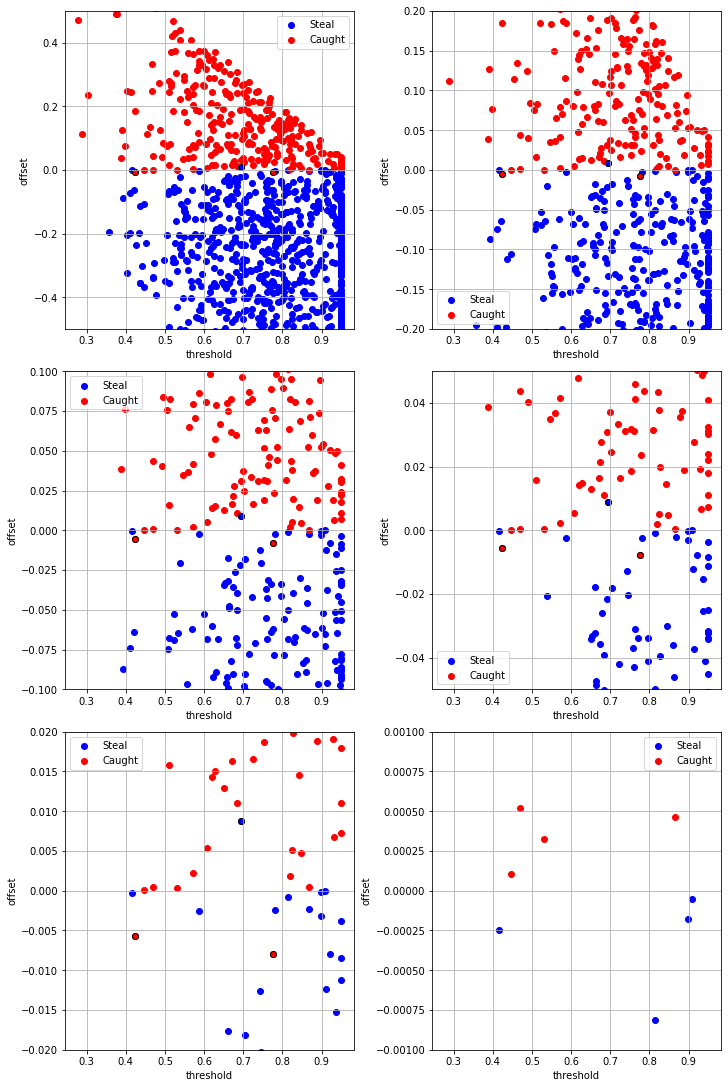

In [46]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-1, 2e-1, 1e-1, 0.5e-1, 0.2e-1, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Caught",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')

In [49]:
# pd.set_option("display.max_rows", None)

# dfc.loc[2050, ['roll', 'threshold']]